In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from utils import *


In [12]:

def find_turn_indices(angVels, ht=np.pi/3, eps=0):

	turn_idxs = []
	peaks = []

	exceed_indices = np.where(angVels > ht)[0]
	result_segments = indices_grouped_by_condition(angVels, lambda x: x > eps)
	for seg in result_segments:
		if len(seg)<=2:
			continue
		turn = (seg[0], seg[-1])
		if is_number_in_interval(exceed_indices, turn):
			turn_idxs.append(turn)
			peaks.append(int((turn[0]+turn[1])/2))

	exceed_indices = np.where(angVels < -ht)[0]
	result_segments = indices_grouped_by_condition(angVels, lambda x: x < -eps)
	for seg in result_segments:
		if len(seg)<=2:
			continue
		turn = (seg[0], seg[-1])
		if is_number_in_interval(exceed_indices, turn):
			turn_idxs.append(turn)
			peaks.append(int((turn[0]+turn[1])/2))

	# Zip the arrays together
	paired_arrays = list(zip(peaks, turn_idxs))
	# Sort the paired arrays based on the first array
	sorted_paired_arrays = sorted(paired_arrays, key=lambda x: x[0])
	# Unzip the sorted paired arrays
	if len(sorted_paired_arrays) == 0:
		return [], []
	peaks, turn_idxs = map(list, zip(*sorted_paired_arrays))

	return peaks, turn_idxs

def get_turns(ht=np.pi/3, output_file='test.output'):
	
	all_turns = []
	all_peak_times = []
	angle1 = []
	angle2 = []
	turn_lengths = []
	in_box_angles = []

	f1 = open(output_file, 'rb')
	data = pickle.load(f1)
	f1.close()

	for i in range(len(data)):
		
		angles, angVels = data[i]

		reprocess_angles = (angles + np.pi)%(2*np.pi) - np.pi

		# To be used for normalizing to amount of time spent facing each direction
		in_box_angles.append(reprocess_angles)

		# Find turns using angVels
		peaks, turn_idxs = find_turn_indices(angVels, ht = ht)

		for k,turn_idx in enumerate(turn_idxs):
			# conditional to make sure indices dont go out
			turn0, turn1 = turn_idx[0], turn_idx[1]
			
			# Get difference of ingoing vs outgoing angle
			turn_angle = angles[turn1] - angles[turn0]

			all_peak_times.append(peaks[k])
			angle1.append(reprocess_angles[turn0])
			angle2.append(reprocess_angles[turn1])
			all_turns.append(turn_angle)
			turn_lengths.append((turn1-turn0))

	return all_turns, all_peak_times, angle1, angle2, turn_lengths, in_box_angles

def polar_turns(ht=np.pi/3, plot_name='test', mode = None, output_file = 'test.output'):

	outputDir = f'plots/{plot_name}/'
	create_directory(outputDir)

	all_turns, all_peak_times, angle1, angle2, turn_lengths, in_box_angles = get_turns(ht=ht, output_file=output_file)

	angle1 = np.array(angle1)
	angle_diff_reprocess = (180/np.pi)*np.array(all_turns)

	# Plot to see conditional distribution
	nbins = 8
	bins = np.linspace(-np.pi, np.pi, nbins+1)
	mid_angles = (bins[1:] + bins[:-1])/2
	inds = np.digitize(angle1, bins)

	df = pd.DataFrame({'Angle1': angle1, 'Angle_diff': angle_diff_reprocess , 'inds_Angle1': inds, 'peaks': all_peak_times})

	if mode is None:
		dfs = [df]
		fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,6))
		ax = [ax]

	elif mode  == 'stratify':
		bdry = 60
		dfs = [df[df.peaks < bdry], df[df.peaks >= bdry]]
		fig, ax = plt.subplots(1,2,subplot_kw={'projection': 'polar'}, figsize=(12,6))
		ax[0].set_title(f'First {bdry} seconds')
		ax[1].set_title(f'After {bdry} seconds')

	for i,df in enumerate(dfs):
		# print(len(df))
		lCountNorm, rCountNorm = np.zeros(nbins), np.zeros(nbins)
		for k in range(nbins):
			df_subset = df[df.inds_Angle1 == (k+1)]
			pos = df_subset[df_subset['Angle_diff'] > 0].shape[0]
			neg = df_subset[df_subset['Angle_diff'] < 0].shape[0]
			lCountNorm[k] = pos/(pos+neg)
			rCountNorm[k] = neg/(pos+neg)

		p1 = ax[i].bar(mid_angles,rCountNorm,width = (2 * np.pi / nbins), color='purple',edgecolor='k',linewidth=1.5)
		p3 = ax[i].bar(mid_angles,lCountNorm,width = (2 * np.pi / nbins), color='green', bottom =rCountNorm,edgecolor='k',linewidth=1.5)

		ax[i].legend((p1[0],p3[0]),('Right','Left'),loc='upper right')
		ax[i].set_xlabel('Incoming angle')
		ax[i].set_rorigin(-1.0)
		ax[i].set_ylim([0,1])
		ax[i].xaxis.grid(False)
		ax[i].set_aspect('equal')

	fig.suptitle(plot_name)
	fig.tight_layout()

	fig.savefig(outputDir+'polar_turns.png', transparent=True)
	# fig.savefig(outputDir_png + default +groupName+'.png')

In [9]:
tauh = 1.0
taug = 4.0
alpha = 1.0
sigma = 0.1

nits = 500

tfinal = 1000
dt = 0.1
u = np.array([1, 0])

nsteps = round(tfinal / dt)
all_angles = []

data = []

for kk in range(nits):

	vh = np.random.randn(2)
	vh = vh / np.linalg.norm(vh)
	
	angles = [np.arctan2(vh[1], vh[0])]

	vg = np.random.randn(2)
	vg = vg / np.linalg.norm(vg)

	x = np.zeros(2)
	xsave = np.zeros((2, nsteps + 1))

	for k in range(nsteps):
		vhn = vh / np.linalg.norm(vh)
		vgn = vg / np.linalg.norm(vg)

		dvh = (vgn - vh) * dt / tauh + sigma * np.sqrt(dt) * np.random.randn(2)
		dvg = (np.exp(1 + alpha * np.dot(u, vgn)) * vhn - vg) * dt / taug
		dx = vh * dt

		vh = vh + dvh
		vh = vh / np.linalg.norm(vh)
		vg = vg + dvg
		x = x + dx

		angles.append(np.arctan2(vh[1], vh[0]))

		xsave[:, k + 1] = x
	
	angles = np.unwrap(angles)
	all_angles.append(angles)
	data.append((angles, np.gradient(angles, dt)))

all_angles = np.array(all_angles)

output_name = 'test.out'
f1 = open('outputs/'+output_name,'wb')
pickle.dump(data,f1)
f1.close()

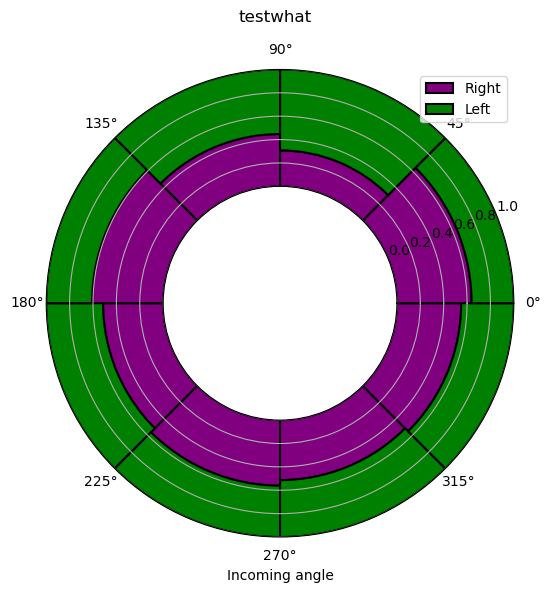

In [15]:
output_file = 'outputs/test.out'
name = 'testwhat'

turn_thresh = np.pi/3

polar_turns(ht=turn_thresh, plot_name = name, output_file=output_file)